# DSBA Coding Test - CV

- **이름**:  김태경

이미지 데이터 학습을 위한 코드와 결과물 정리 코드 작성입니다.

실험 및 상세 조건들은 아래와 같습니다.

- 모든 코드는 colab을 사용하여 notebook 파일 내 작성

1. 주제 : 이미지 데이터 학습을 위한 코드 및 결과물 정리
    - 실험을 위한 모델 코드와 학습 및 평가 코드 작성
    - 실험 결과 작성
2. 학습 모델
    - ResNet50
    - ViT-S/16
3. 실험 항목
    1. ResNet50 w/o pre-trained weights
    2. ViT-S/16 w/o pre-trained weights
    3. ResNet50 w/ pre-trained on ImageNet 1k
    4. ViT-S/16 w/ pre-trained on ImageNet 1k
4. 실험 결과
    - 결과로 보일 수 있는 Table, Figure 모두 작성

# Data Download

In [1]:
import gdown

url = "https://drive.google.com/drive/folders/1wEnwMeJoQZwJhI7oBRah3I8QX-FpLMYD"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/data/test_data.npy',
 '/content/data/test_target.npy',
 '/content/data/train_data.npy',
 '/content/data/train_target.npy']

# Import Modules

실험에 사용된 module은 모두 아래 cell에서 불러와주세요.

In [3]:
!pip install timm
!pip install omegaconf
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [22]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

from torchsummary import summary

from einops import rearrange, repeat
from einops.layers.torch import Rearrange, Reduce

from torcheval.metrics import (
    MulticlassAccuracy,
    MulticlassF1Score,
    MulticlassPrecision,
    MulticlassRecall,
)

from torch.optim.lr_scheduler import CosineAnnealingLR

import timm
from omegaconf import OmegaConf


# Configuration

코드에 사용된 설정 값은 모두 `cfg`에 정의해주세요.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/DSBA conding test

/content/drive/MyDrive/DSBA conding test


In [23]:
cfg = OmegaConf.load('./config.yaml')
print(cfg.settings)

{'num_classes': 10, 'batch_size': 32, 'num_workers': 1, 'epochs': 30, 'save_dir': './outputs', 'image_size': 224, 'normalize': {'mean': [0.5, 0.5, 0.5], 'std': [0.5, 0.5, 0.5]}, 'early_stopping_patience': 10}


# Datasets

실험에 사용할 데이터를 구성해주세요.  

20431
10000
(32, 32, 3)


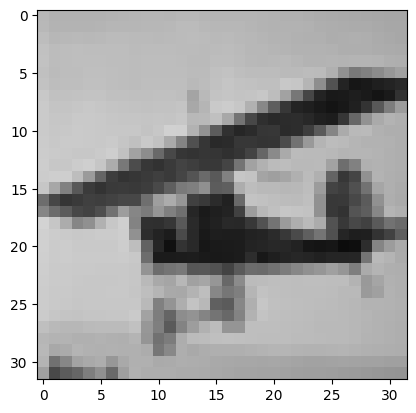

In [24]:
train_data = np.load("data/train_data.npy")
train_labels = np.load("data/train_target.npy")
test_data = np.load("data/test_data.npy")
test_labels = np.load("data/test_target.npy")

print(len(train_data))
print(len(test_data))
print(train_data[0].shape)
plt.imshow(train_data[0])


In [5]:
print(len(set(train_labels)), len(set(test_labels)))
print(set(train_labels), set(test_labels))

10 10
{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)} {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)}


In [25]:

class ImageDataset(Dataset):
    def __init__(self, imgs, labels, cfg, target_transform=None):
        self.imgs = imgs
        self.labels = labels
        self.target_transform = target_transform
        self.transform = transforms.Compose([
            transforms.Resize((cfg.image_size, cfg.image_size)),
            transforms.ToTensor(),  # PIL 이미지 -> Tensor
            transforms.Normalize(mean=cfg.normalize.mean, std=cfg.normalize.std)
        ])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        label = self.labels[idx]

        # numpy 배열 -> PIL 이미지로 변환
        if img.ndim == 3:
            if img.shape[-1] in {1,3,4}:
                img = Image.fromarray((img * 255).astype('uint8'))
            else:
                raise ValueError(f"지원하지 않는 이미지 shape입니다: {img.shape}")
        else:
            raise ValueError(f"지원하지 않는 이미지 ndim입니다: {img.ndim}")

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(label)
        if self.target_transform:
            label = self.target_transform(label)

        return img, label


In [26]:
# Dataset 생성
train_dataset = ImageDataset(train_data, train_labels, cfg.settings)
test_dataset  = ImageDataset(test_data,  test_labels, cfg.settings)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=cfg.settings.batch_size, shuffle=True, num_workers=cfg.settings.num_workers)
test_loader  = DataLoader(test_dataset,  batch_size=cfg.settings.batch_size, shuffle=False, num_workers=cfg.settings.num_workers)

# Models

`ResNet50`과 `ViT-S/16` 두 모델을 작성해주세요.
- `ResNet50`은 torch를 사용하여 작성해주세요.
- `ViT-S/16`은 open source를 사용하여 불러와도 괜찮습니다.

ResNet50 code

In [8]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))

        x = self.relu(self.batch_norm2(self.conv2(x)))

        x = self.conv3(x)
        x = self.batch_norm3(x)

        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)

        return x



class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(num_channels, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock, layer_list[0], out_channels=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, ResBlock, blocks, out_channels, stride=1):
        ii_downsample = None
        layers = []

        if stride != 1 or self.in_channels != out_channels*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels*ResBlock.expansion)
            )

        layers.append(ResBlock(self.in_channels, out_channels, i_downsample=ii_downsample, stride=stride))
        self.in_channels = out_channels*ResBlock.expansion

        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, out_channels))

        return nn.Sequential(*layers)



def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)

ViT-S/16

In [32]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224):
        super().__init__()
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        self.projection = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.positions = nn.Parameter(torch.randn(1, self.n_patches + 1, emb_size))

    def forward(self, x):
        b, _, _, _ = x.shape
        # Patch embedding
        x = self.projection(x)  # (b, emb_size, h', w')
        x = rearrange(x, 'b e h w -> b (h w) e')  # (b, n_patches, emb_size)

        # Add CLS token
        cls_tokens = repeat(self.cls_token, '1 1 e -> b 1 e', b=b)
        x = torch.cat([cls_tokens, x], dim=1)  # (b, n_patches + 1, emb_size)

        # Add positional encoding
        x = x + self.positions
        return x


class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return x + self.fn(x, **kwargs)


class FeedForwardBlock(nn.Module):
    def __init__(self, emb_size, expansion=4, drop_p=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

    def forward(self, x):
        return self.net(x)


class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size=768, num_heads=8, dropout=0.):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.head_dim = emb_size // num_heads

        assert emb_size % num_heads == 0, f"Embedding size {emb_size} must be divisible by number of heads {num_heads}"

        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x, mask=None):
        qkv = rearrange(self.qkv(x), 'b n (qkv h d) -> qkv b h n d', qkv=3, h=self.num_heads)
        queries, keys, values = qkv[0], qkv[1], qkv[2]

        scale = math.sqrt(self.head_dim)
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) / scale

        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.masked_fill_(~mask, fill_value)

        att = F.softmax(energy, dim=-1)
        att = self.att_drop(att)

        out = torch.einsum('bhqk, bhvd -> bhqd', att, values)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.projection(out)


class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_size=768, drop_p=0., forward_expansion=4, forward_drop_p=0., **kwargs):
        super().__init__()
        self.attention_block = ResidualAdd(nn.Sequential(
            nn.LayerNorm(emb_size),
            MultiHeadAttention(emb_size, **kwargs),
            nn.Dropout(drop_p),
        ))
        self.feedforward_block = ResidualAdd(nn.Sequential(
            nn.LayerNorm(emb_size),
            FeedForwardBlock(emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
            nn.Dropout(drop_p),
        ))

    def forward(self, x):
        x = self.attention_block(x)
        x = self.feedforward_block(x)
        return x


class TransformerEncoder(nn.Module):
    def __init__(self, depth=12, **kwargs):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderBlock(**kwargs) for _ in range(depth)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class ClassificationHead(nn.Module):
    def __init__(self, emb_size=768, num_classes=1000):
        super().__init__()
        self.norm = nn.LayerNorm(emb_size)
        self.head = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        # CLS token 사용 (첫 번째 토큰)
        cls_token = x[:, 0]  # (b, emb_size)
        cls_token = self.norm(cls_token)
        return self.head(cls_token)


class ViTS_16(nn.Module):
    def __init__(self,
                 in_channels=3,
                 patch_size=16,
                 emb_size=384,
                 img_size=224,
                 depth=12,
                 num_classes=10,
                 num_heads=6,
                 drop_p=0.1,
                 forward_drop_p=0.1):
        super().__init__()
        self.patch_embedding = PatchEmbedding(in_channels, patch_size, emb_size, img_size)
        self.transformer = TransformerEncoder(
            depth=depth,
            emb_size=emb_size,
            num_heads=num_heads,
            drop_p=drop_p,
            forward_drop_p=forward_drop_p
        )
        self.classification_head = ClassificationHead(emb_size, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.transformer(x)
        x = self.classification_head(x)
        return x

# Evaluation Metrics

평가에 사용할 코드를 작성하세요.

In [28]:

metrics_factory = {
    "acc": MulticlassAccuracy,
    "f1": lambda num_classes: MulticlassF1Score(num_classes=num_classes, average="macro"),
    "precision": lambda num_classes: MulticlassPrecision(num_classes=num_classes, average="macro"),
    "recall": lambda num_classes: MulticlassRecall(num_classes=num_classes, average="macro"),
}

# Training & Evaluation

학습 및 평가 코드를 작성하세요.

In [29]:

def get_scheduler(optimizer, scheduler_cfg):
    name = scheduler_cfg.name.lower()

    if name == "cosineannealinglr":
        return CosineAnnealingLR(
            optimizer,
            T_max=scheduler_cfg.T_max
        )
    elif name == "steplr":
        return optim.lr_scheduler.StepLR(
            optimizer,
            step_size=scheduler_cfg.step_size,
            gamma=scheduler_cfg.gamma
        )
    elif name == "reducelronplateau":
        return optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            factor=scheduler_cfg.get("factor", 0.1),
            patience=scheduler_cfg.get("patience", 10)
        )
    else:
        raise ValueError(f"Unsupported scheduler: {scheduler_cfg.name}")


def train_epoch(model, dataloader, criterion, optimizer, device, num_classes):
    model.train()
    total_loss = 0

    # metric 객체 생성 (학습에서는 보통 acc 정도만 써도 무방)
    accuracy = metrics_factory["acc"]()
    progress_bar = tqdm(dataloader, desc="Training", leave=False)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)

        # metric 업데이트
        preds = torch.argmax(outputs, dim=1)
        accuracy.update(preds, labels)
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(dataloader.dataset)
    avg_acc = accuracy.compute().item()
    accuracy.reset()

    return avg_loss, avg_acc

def evaluate(model, dataloader, criterion, device, num_classes):
    model.eval()
    total_loss = 0

    accuracy = metrics_factory["acc"]()
    f1 = metrics_factory["f1"](num_classes)
    precision = metrics_factory["precision"](num_classes)
    recall = metrics_factory["recall"](num_classes)


    progress_bar = tqdm(dataloader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            preds = torch.argmax(outputs, dim=1)
            accuracy.update(preds, labels)
            f1.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)

    avg_loss = total_loss / len(dataloader.dataset)
    avg_acc = accuracy.compute().item()
    avg_f1 = f1.compute().item()
    avg_precision = precision.compute().item()
    avg_recall = recall.compute().item()

    # metric 리셋
    accuracy.reset()
    f1.reset()
    precision.reset()
    recall.reset()

    return avg_loss, avg_acc, avg_f1, avg_precision, avg_recall



# Experiments

실험 코드를 작성하세요.

In [33]:
# 모델 맵핑: config의 model_name 문자열 → 실제 클래스/함수 매핑
model_map = {
    "resnet50": ResNet50,
    "vit_small_patch16_224": ViTS_16  # 해당 키와 일치함
}

# 옵티마이저 맵핑: config 문자열 → torch.optim 옵티마이저 클래스 매핑
optimizer_map = {
    "adam": optim.Adam,
    "adamw": optim.AdamW,
    "sgd": optim.SGD,
}


In [35]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # 여기만 수정하게끔
    # model_cfg = cfg.models.resnet50
    # model_cfg = cfg.models.resnet50_pretrained
    # model_cfg = cfg.models.vit_small
    model_cfg = cfg.models.vit_small_pretrained

    model_cls = model_map[model_cfg.model_name]

    pretrained = getattr(model_cfg, "pretrained", False)


    if pretrained:
        if "vit" in model_cfg.model_name:
            model = timm.create_model(
                model_cfg.model_name,
                pretrained=True,
                num_classes=cfg.settings.num_classes,
                img_size=cfg.settings.image_size,
            ).to(device)
            print(model)
        else:
            model = timm.create_model(
                model_cfg.model_name,
                pretrained=True,
                num_classes=cfg.settings.num_classes,
            ).to(device)
            print(model)
    else:
        if "vit" in model_cfg.model_name:
            model = model_cls(
                num_classes=cfg.settings.num_classes,
                img_size=cfg.settings.image_size,
                patch_size=getattr(model_cfg, "patch_size", 16),
                in_channels=model_cfg.in_channels
            ).to(device)
            print(model)
        else:
            model = model_cls(num_classes=cfg.settings.num_classes).to(device)
            print(model)


    criterion = nn.CrossEntropyLoss()
    optimizer_cls = optimizer_map[model_cfg.optimizer]
    optimizer = optimizer_cls(model.parameters(), lr=model_cfg.learning_rate)

    model_name_for_saving = [k for k, v in cfg.models.items() if v == model_cfg][0]
    scheduler = get_scheduler(optimizer, model_cfg.scheduler)

    early_stopping_patience  = cfg.settings.early_stopping_patience

    # 저장 디렉토리 및 로그 파일 설정
    os.makedirs(cfg.settings.save_dir, exist_ok=True)
    save_path = save_path = os.path.join(cfg.settings.save_dir, f"{model_name_for_saving}.pt")
    log_path = os.path.join(cfg.settings.save_dir, f"{model_name_for_saving}_val.txt")
    checkpoint_path = cfg.settings.get("checkpoint_path", None)

    best_val_acc = 0.0
    start_epoch = 1
    no_improve_count = 0

    # 체크포인트가 있으면 로드 (이어 학습)
    # if checkpoint_path and os.path.exists(checkpoint_path):
    #     print(f"Checkpoint found at {checkpoint_path}, loading...")
    #     checkpoint = torch.load(checkpoint_path, map_location=device)
    #     model.load_state_dict(checkpoint['model_state_dict'])
    #     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    #     scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    #     best_val_acc = checkpoint.get('best_val_acc', 0.0)
    #     start_epoch = checkpoint.get('epoch', 0) + 1
    #     print(f"Resuming from epoch {start_epoch}")

    with open(log_path, "w") as f:
        f.write("Epoch\tTrainLoss\tTrainAcc\tValLoss\tValAcc\tValF1\tValPrecision\tValRecall\n")

    epochs = cfg.settings.epochs

    for epoch in range(start_epoch, epochs + 1):
        print(f"\n[Epoch {epoch:02d}]")

        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device, cfg.settings.num_classes
        )
        val_loss, val_acc, val_f1, val_prec, val_rec = evaluate(
            model, test_loader, criterion, device, cfg.settings.num_classes
        )

        # 스케줄러 step
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)  # val_loss 기반 스케줄러는 따로 호출
        else:
            scheduler.step()

        print(f"  Train Loss     : {train_loss:.4f} | Train Acc    : {train_acc:.4f}")
        print(f"  Val Loss       : {val_loss:.4f} | Val Acc      : {val_acc:.4f}")
        print(f"  Val F1         : {val_f1:.4f} | Precision    : {val_prec:.4f} | Recall: {val_rec:.4f}")

        with open(log_path, "a") as f:
            f.write(f"{epoch}\t{train_loss:.4f}\t{train_acc:.4f}\t{val_loss:.4f}\t{val_acc:.4f}\t{val_f1:.4f}\t{val_prec:.4f}\t{val_rec:.4f}\n")

        # 최고 성능 모델 저장 + early stopping (config -> patience 10으로 설정)
        if val_acc > best_val_acc:
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "best_val_acc": val_acc,
            }, save_path)
            best_val_acc = val_acc
            no_improve_count = 0
            print(f"  ✅ Best model updated and saved to {save_path}")
        else:
          no_improve_count += 1
          print(f"  ⚠️ No improvement count: {no_improve_count} / {early_stopping_patience}")

        if no_improve_count >= early_stopping_patience:
            print(f"\nEarly stopping triggered after {no_improve_count} epochs without improvement.")
            break

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

  Train Loss     : 1.4848 | Train Acc    : 0.5316
  Val Loss       : 1.3936 | Val Acc      : 0.5312
  Val F1         : 0.4565 | Precision    : 0.6267 | Recall: 0.5312
  ✅ Best model updated and saved to ./outputs/vit_small_pretrained.pt

[Epoch 02]


  Train Loss     : 0.5991 | Train Acc    : 0.8398
  Val Loss       : 0.6289 | Val Acc      : 0.8256
  Val F1         : 0.8206 | Precision    : 0.8602 | Recall: 0.8256
  ✅ Best model updated and saved to ./outputs/vit_small_pretrained.pt

[Epoch 03]


  Train Loss     : 0.3064 | Train Acc    : 0.9313
  Val Loss       : 0.3642 | Val Acc      : 0.9134
  Val F1         : 0.9129 | Precision    : 0.9215 | Recall: 0.9134
  ✅ Best model updated and saved to ./outputs/vit_small_pretrained.pt

[Epoch 04]


  Train Loss     : 0.1996 | Train Acc    : 0.9571
  Val Loss       : 0.2626 | Val Acc      : 0.9380
  Val F1         : 0.9379 | Precision    : 0.9416 | Recall: 0.9380
  ✅ Best model updated and saved to ./outputs/vit_small_pretrained.pt

[Epoch 05]


  Train Loss     : 0.1509 | Train Acc    : 0.9668
  Val Loss       : 0.2074 | Val Acc      : 0.9488
  Val F1         : 0.9488 | Precision    : 0.9508 | Recall: 0.9488
  ✅ Best model updated and saved to ./outputs/vit_small_pretrained.pt

[Epoch 06]


  Train Loss     : 0.1235 | Train Acc    : 0.9716
  Val Loss       : 0.1774 | Val Acc      : 0.9541
  Val F1         : 0.9541 | Precision    : 0.9557 | Recall: 0.9541
  ✅ Best model updated and saved to ./outputs/vit_small_pretrained.pt

[Epoch 07]


  Train Loss     : 0.1059 | Train Acc    : 0.9750
  Val Loss       : 0.1576 | Val Acc      : 0.9584
  Val F1         : 0.9584 | Precision    : 0.9597 | Recall: 0.9584
  ✅ Best model updated and saved to ./outputs/vit_small_pretrained.pt

[Epoch 08]


  Train Loss     : 0.0933 | Train Acc    : 0.9781
  Val Loss       : 0.1434 | Val Acc      : 0.9605
  Val F1         : 0.9605 | Precision    : 0.9615 | Recall: 0.9605
  ✅ Best model updated and saved to ./outputs/vit_small_pretrained.pt

[Epoch 09]


  Train Loss     : 0.0838 | Train Acc    : 0.9802
  Val Loss       : 0.1331 | Val Acc      : 0.9621
  Val F1         : 0.9621 | Precision    : 0.9630 | Recall: 0.9621
  ✅ Best model updated and saved to ./outputs/vit_small_pretrained.pt

[Epoch 10]


  Train Loss     : 0.0762 | Train Acc    : 0.9814
  Val Loss       : 0.1257 | Val Acc      : 0.9640
  Val F1         : 0.9640 | Precision    : 0.9648 | Recall: 0.9640
  ✅ Best model updated and saved to ./outputs/vit_small_pretrained.pt

[Epoch 11]


  Train Loss     : 0.0700 | Train Acc    : 0.9830
  Val Loss       : 0.1188 | Val Acc      : 0.9660
  Val F1         : 0.9660 | Precision    : 0.9667 | Recall: 0.9660
  ✅ Best model updated and saved to ./outputs/vit_small_pretrained.pt

[Epoch 12]


  Train Loss     : 0.0647 | Train Acc    : 0.9843
  Val Loss       : 0.1139 | Val Acc      : 0.9670
  Val F1         : 0.9670 | Precision    : 0.9676 | Recall: 0.9670
  ✅ Best model updated and saved to ./outputs/vit_small_pretrained.pt

[Epoch 13]


  Train Loss     : 0.0601 | Train Acc    : 0.9856
  Val Loss       : 0.1104 | Val Acc      : 0.9677
  Val F1         : 0.9677 | Precision    : 0.9683 | Recall: 0.9677
  ✅ Best model updated and saved to ./outputs/vit_small_pretrained.pt

[Epoch 14]


  Train Loss     : 0.0561 | Train Acc    : 0.9864
  Val Loss       : 0.1059 | Val Acc      : 0.9683
  Val F1         : 0.9683 | Precision    : 0.9688 | Recall: 0.9683
  ✅ Best model updated and saved to ./outputs/vit_small_pretrained.pt

[Epoch 15]


  Train Loss     : 0.0526 | Train Acc    : 0.9867
  Val Loss       : 0.1031 | Val Acc      : 0.9688
  Val F1         : 0.9688 | Precision    : 0.9693 | Recall: 0.9688
  ✅ Best model updated and saved to ./outputs/vit_small_pretrained.pt

[Epoch 16]


  Train Loss     : 0.0494 | Train Acc    : 0.9878
  Val Loss       : 0.1008 | Val Acc      : 0.9693
  Val F1         : 0.9693 | Precision    : 0.9698 | Recall: 0.9693
  ✅ Best model updated and saved to ./outputs/vit_small_pretrained.pt

[Epoch 17]


  Train Loss     : 0.0465 | Train Acc    : 0.9884
  Val Loss       : 0.0981 | Val Acc      : 0.9701
  Val F1         : 0.9701 | Precision    : 0.9705 | Recall: 0.9701
  ✅ Best model updated and saved to ./outputs/vit_small_pretrained.pt

[Epoch 18]


  Train Loss     : 0.0438 | Train Acc    : 0.9895
  Val Loss       : 0.0971 | Val Acc      : 0.9706
  Val F1         : 0.9706 | Precision    : 0.9710 | Recall: 0.9706
  ✅ Best model updated and saved to ./outputs/vit_small_pretrained.pt

[Epoch 19]


  Train Loss     : 0.0414 | Train Acc    : 0.9903
  Val Loss       : 0.0951 | Val Acc      : 0.9708
  Val F1         : 0.9708 | Precision    : 0.9712 | Recall: 0.9708
  ✅ Best model updated and saved to ./outputs/vit_small_pretrained.pt

[Epoch 20]


  Train Loss     : 0.0391 | Train Acc    : 0.9911
  Val Loss       : 0.0946 | Val Acc      : 0.9706
  Val F1         : 0.9706 | Precision    : 0.9710 | Recall: 0.9706
  ⚠️ No improvement count: 1 / 10

[Epoch 21]


  Train Loss     : 0.0370 | Train Acc    : 0.9921
  Val Loss       : 0.0931 | Val Acc      : 0.9712
  Val F1         : 0.9712 | Precision    : 0.9716 | Recall: 0.9712
  ✅ Best model updated and saved to ./outputs/vit_small_pretrained.pt

[Epoch 22]


  Train Loss     : 0.0351 | Train Acc    : 0.9924
  Val Loss       : 0.0916 | Val Acc      : 0.9714
  Val F1         : 0.9714 | Precision    : 0.9718 | Recall: 0.9714
  ✅ Best model updated and saved to ./outputs/vit_small_pretrained.pt

[Epoch 23]


  Train Loss     : 0.0333 | Train Acc    : 0.9933
  Val Loss       : 0.0921 | Val Acc      : 0.9716
  Val F1         : 0.9716 | Precision    : 0.9721 | Recall: 0.9716
  ✅ Best model updated and saved to ./outputs/vit_small_pretrained.pt

[Epoch 24]


  Train Loss     : 0.0317 | Train Acc    : 0.9937
  Val Loss       : 0.0904 | Val Acc      : 0.9716
  Val F1         : 0.9716 | Precision    : 0.9720 | Recall: 0.9716
  ⚠️ No improvement count: 1 / 10

[Epoch 25]


  Train Loss     : 0.0302 | Train Acc    : 0.9944
  Val Loss       : 0.0897 | Val Acc      : 0.9719
  Val F1         : 0.9719 | Precision    : 0.9723 | Recall: 0.9719
  ✅ Best model updated and saved to ./outputs/vit_small_pretrained.pt

[Epoch 26]


  Train Loss     : 0.0287 | Train Acc    : 0.9951
  Val Loss       : 0.0891 | Val Acc      : 0.9717
  Val F1         : 0.9717 | Precision    : 0.9721 | Recall: 0.9717
  ⚠️ No improvement count: 1 / 10

[Epoch 27]


  Train Loss     : 0.0274 | Train Acc    : 0.9952
  Val Loss       : 0.0890 | Val Acc      : 0.9723
  Val F1         : 0.9723 | Precision    : 0.9727 | Recall: 0.9723
  ✅ Best model updated and saved to ./outputs/vit_small_pretrained.pt

[Epoch 28]


  Train Loss     : 0.0262 | Train Acc    : 0.9954
  Val Loss       : 0.0879 | Val Acc      : 0.9718
  Val F1         : 0.9718 | Precision    : 0.9722 | Recall: 0.9718
  ⚠️ No improvement count: 1 / 10

[Epoch 29]


  Train Loss     : 0.0251 | Train Acc    : 0.9959
  Val Loss       : 0.0875 | Val Acc      : 0.9721
  Val F1         : 0.9721 | Precision    : 0.9725 | Recall: 0.9721
  ⚠️ No improvement count: 2 / 10

[Epoch 30]


  Train Loss     : 0.0241 | Train Acc    : 0.9963
  Val Loss       : 0.0875 | Val Acc      : 0.9726
  Val F1         : 0.9726 | Precision    : 0.9730 | Recall: 0.9726
  ✅ Best model updated and saved to ./outputs/vit_small_pretrained.pt


# Table

결과를 나타낼 수 있는 Table을 작성하세요.

| Model             | Pretrained | ValAcc | ValPrecision | ValRecall | ValF1  |
| ------------------- | ---------- | ------ | ------------ | --------- | ------ |
| ResNet50            | w/o        | 0.7270 | 0.7444       | 0.7270    | 0.7284 |
| ResNet50            | w/ ImageNet| 0.9236 | 0.9258       | 0.9236    | 0.9234 |
| ViT-S/16            | w/o        | 0.2243 | 0.1864       | 0.2243    | 0.1587 |
| ViT-S/16            | w/ ImageNet| 0.9726 | 0.9730       | 0.9726    | 0.9726 |


In [55]:
# df = pd.read_csv('/content/drive/MyDrive/DSBA conding test/outputs/resnet50_val.txt', delim_whitespace=True)
# df_pretrained = pd.read_csv('/content/drive/MyDrive/DSBA conding test/outputs/resnet50_pretrained_val.txt', delim_whitespace=True)
# df_vit = pd.read_csv('/content/drive/MyDrive/DSBA conding test/outputs/vit_small_val.txt', delim_whitespace=True)
# df_vit_pretrained = pd.read_csv('/content/drive/MyDrive/DSBA conding test/outputs/vit_small_pretrained_val.txt', delim_whitespace=True)

In [63]:
# print(df['ValAcc'].max())
# print(df['ValF1'].max())
# print(df['ValPrecision'].max())
# print(df['ValRecall'].max())

# print(df_pretrained['ValAcc'].max())
# print(df_pretrained['ValF1'].max())
# print(df_pretrained['ValPrecision'].max())
# print(df_pretrained['ValRecall'].max())

# print(df_vit['ValAcc'].max())
# print(df_vit['ValF1'].max())
# print(df_vit['ValPrecision'].max())
# print(df_vit['ValRecall'].max())

# print(df_vit_pretrained['ValAcc'].max())
# print(df_vit_pretrained['ValF1'].max())
# print(df_vit_pretrained['ValPrecision'].max())
# print(df_vit_pretrained['ValRecall'].max())

# Figures

결과를 표현할 수 있는 Figure를 작성하세요.

/tmp/ipython-input-40-4272240862.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True)


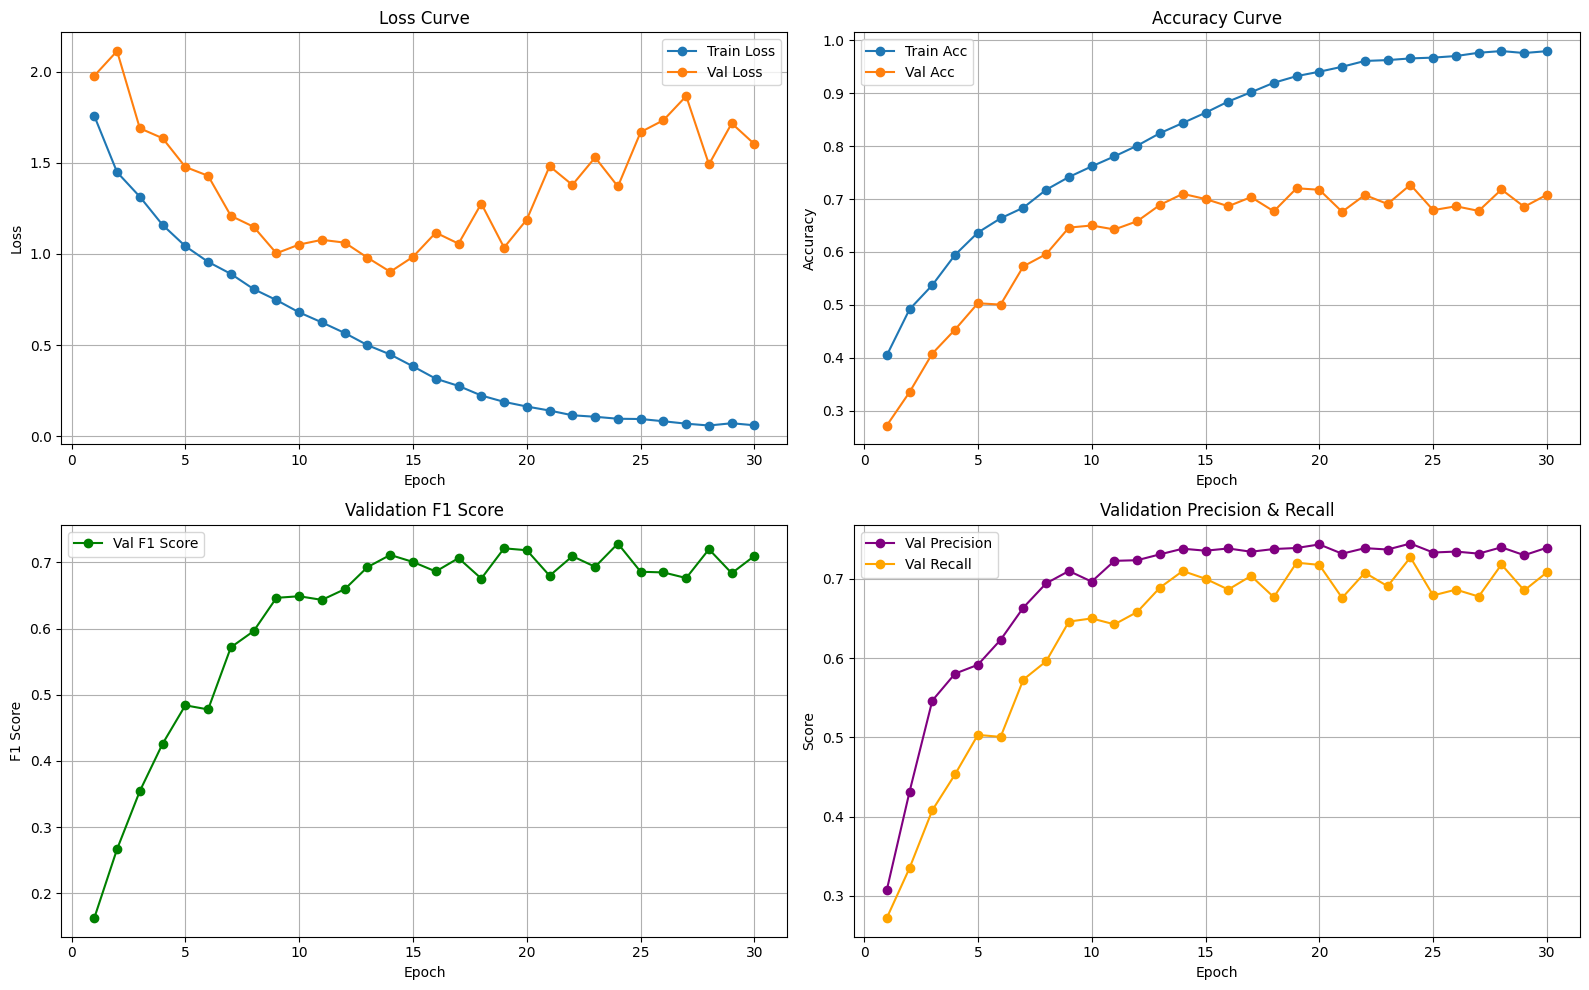

/tmp/ipython-input-40-4272240862.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True)


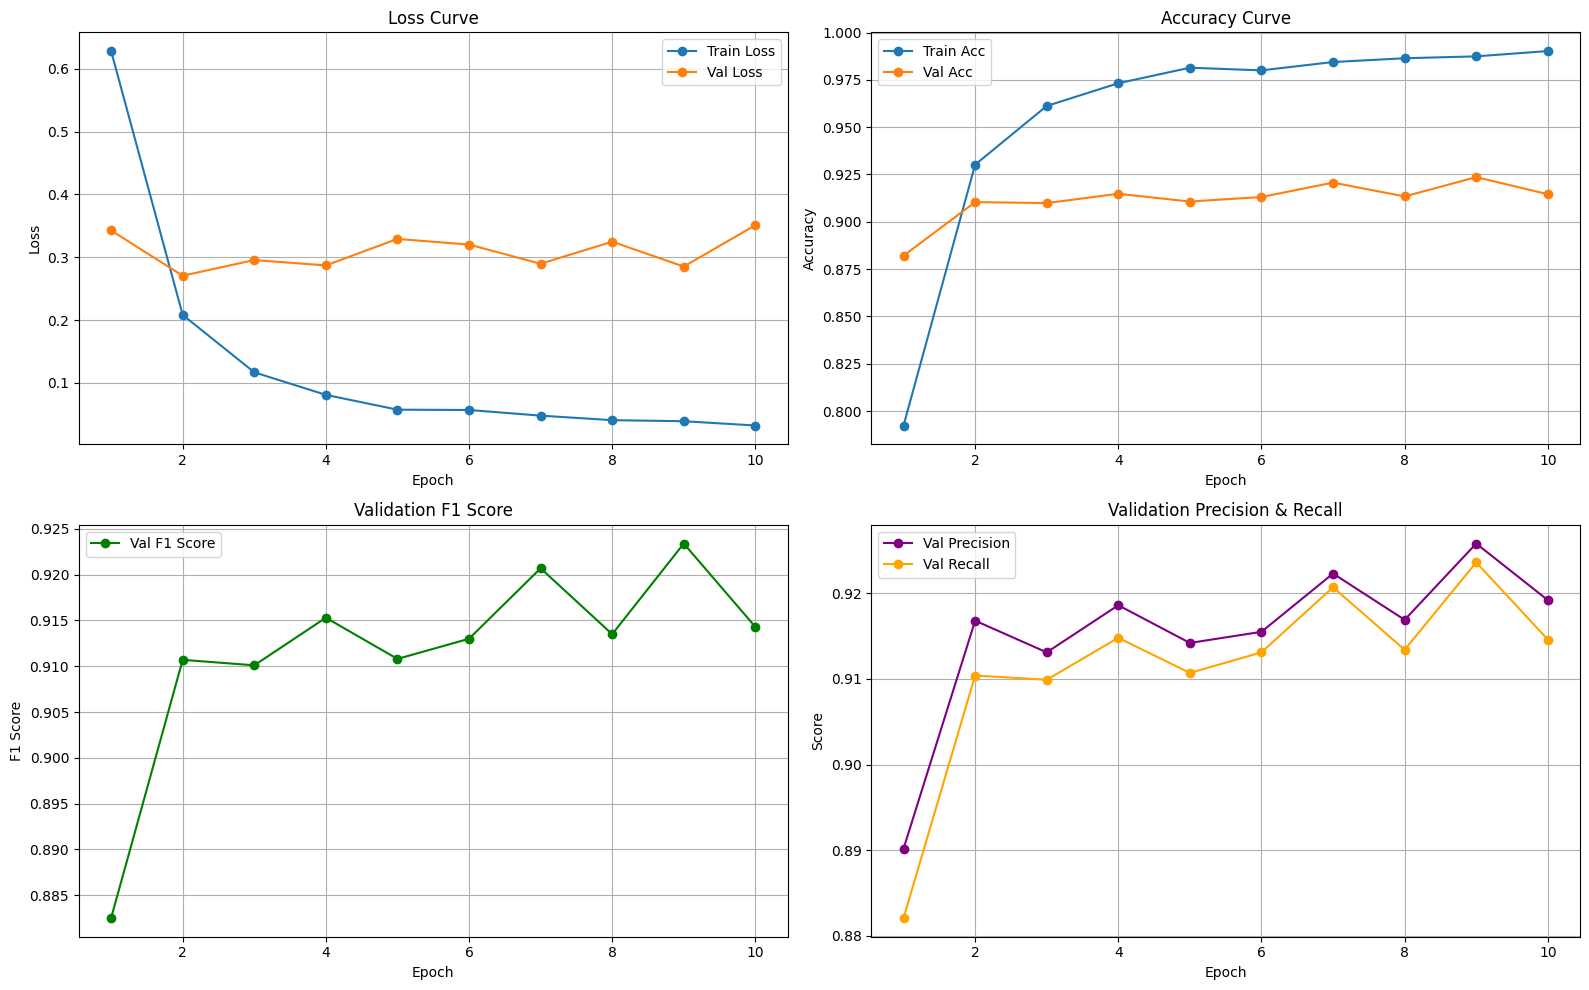

/tmp/ipython-input-40-4272240862.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True)


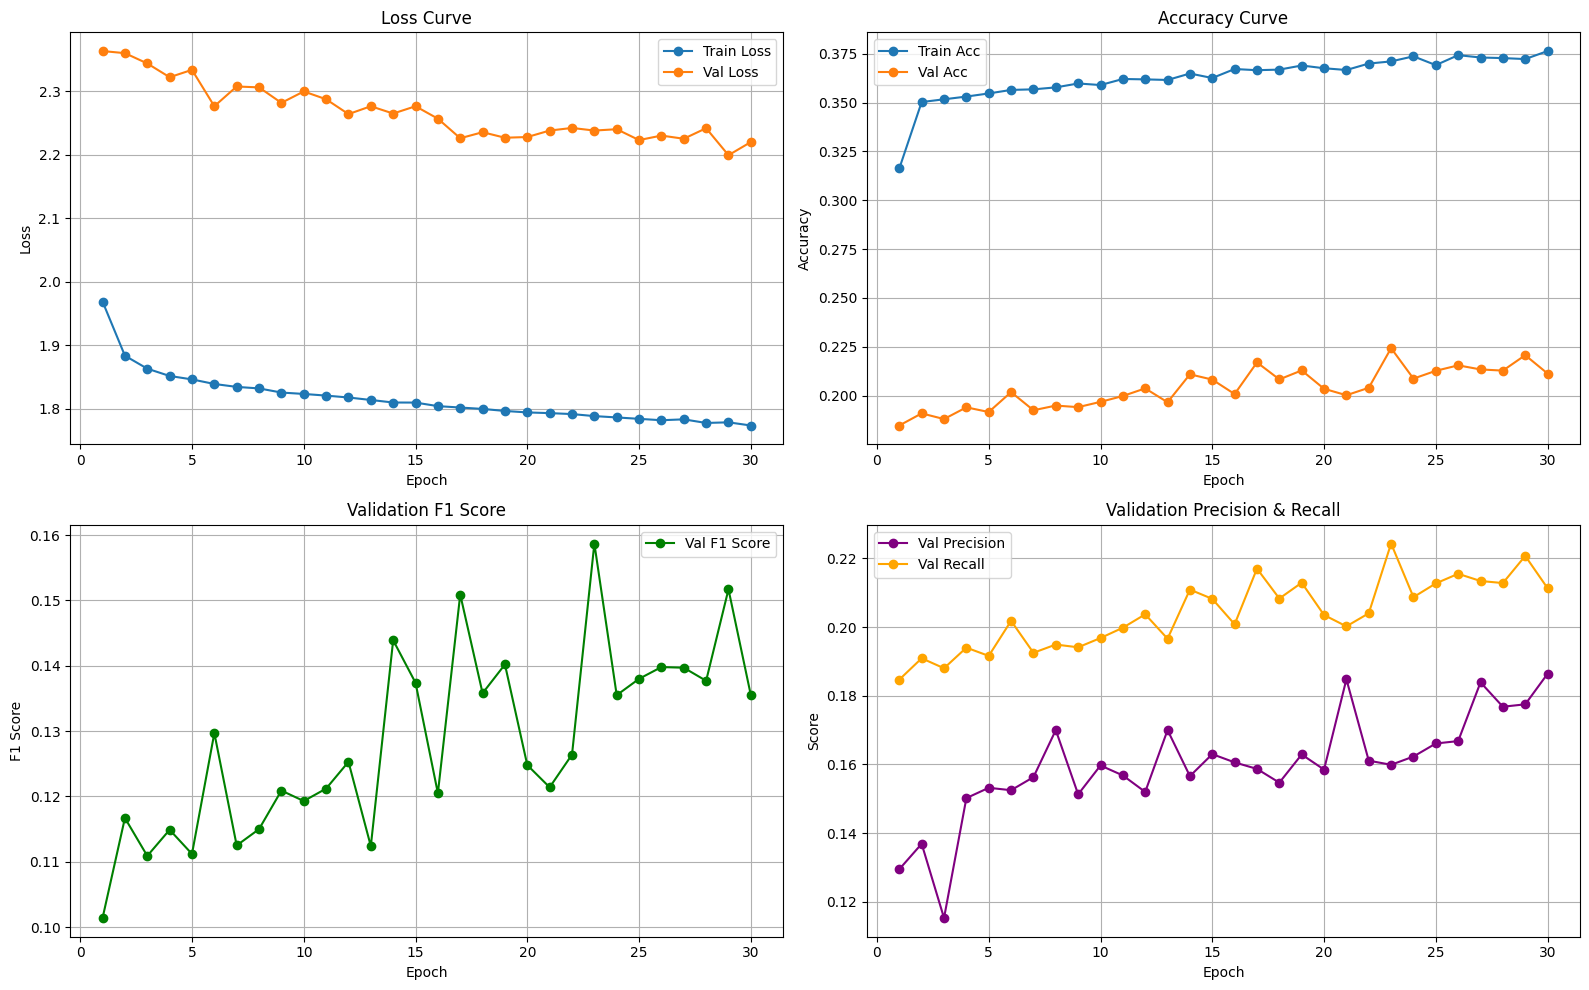

/tmp/ipython-input-40-4272240862.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True)


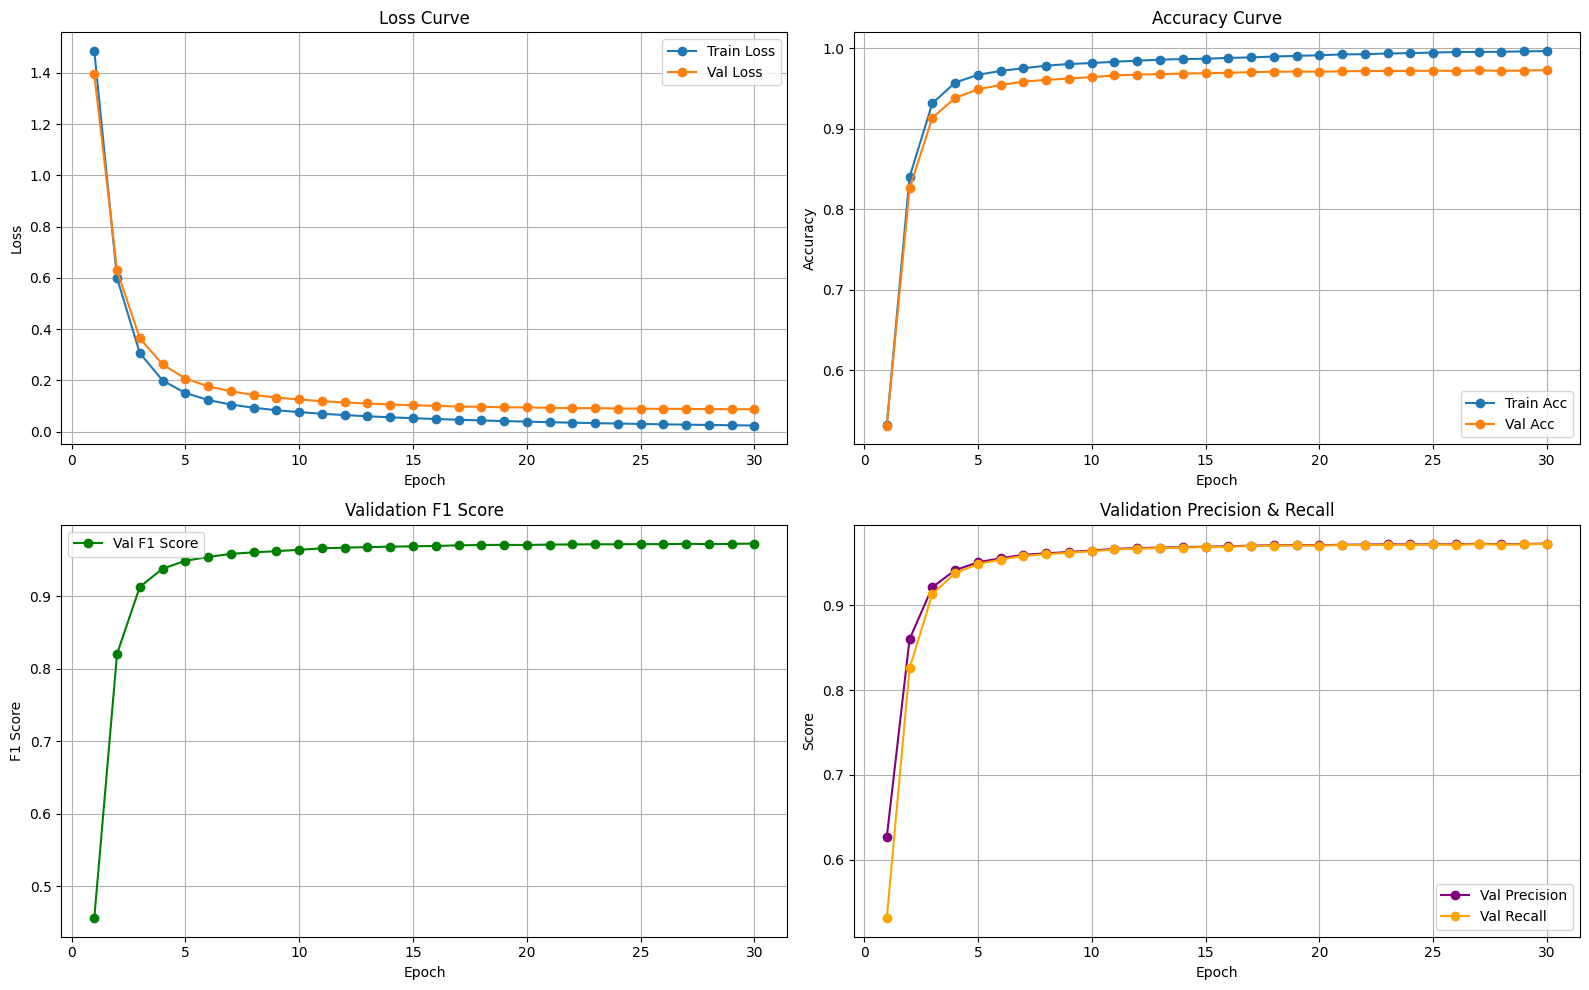

In [40]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def visualize_metrics(file_path: str, save_dir:str, save_name: str):
    os.makedirs(save_dir, exist_ok=True)
    df = pd.read_csv(file_path, delim_whitespace=True)
    plt.figure(figsize=(16, 10))

    # 1. Loss Curve
    plt.subplot(2, 2, 1)
    plt.plot(df['Epoch'], df['TrainLoss'], label='Train Loss', marker='o')
    plt.plot(df['Epoch'], df['ValLoss'], label='Val Loss', marker='o')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. Accuracy Curve
    plt.subplot(2, 2, 2)
    plt.plot(df['Epoch'], df['TrainAcc'], label='Train Acc', marker='o')
    plt.plot(df['Epoch'], df['ValAcc'], label='Val Acc', marker='o')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # 3. F1 Score
    plt.subplot(2, 2, 3)
    plt.plot(df['Epoch'], df['ValF1'], label='Val F1 Score', color='green', marker='o')
    plt.title('Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

    # 4. Precision / Recall
    plt.subplot(2, 2, 4)
    plt.plot(df['Epoch'], df['ValPrecision'], label='Val Precision', color='purple', marker='o')
    plt.plot(df['Epoch'], df['ValRecall'], label='Val Recall', color='orange', marker='o')
    plt.title('Validation Precision & Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    save_path = os.path.join(save_dir, save_name)
    plt.savefig(save_path)
    plt.show()

visualize_metrics("/content/drive/MyDrive/DSBA conding test/outputs/resnet50_val.txt","./figures", 'resnet50_val_metrics.png' )
visualize_metrics("/content/drive/MyDrive/DSBA conding test/outputs/resnet50_pretrained_val.txt","./figures", 'resnet50_pretrained_metrics.png' )
visualize_metrics("/content/drive/MyDrive/DSBA conding test/outputs/vit_small_val.txt","./figures", 'vit_small_val_metrics.png' )
visualize_metrics("/content/drive/MyDrive/DSBA conding test/outputs/vit_small_pretrained_val.txt","./figures", 'vit_small_pretrained_metrics.png' )